# Lossless compression with VAEs
In this notebook, we want to show some practical examples of lossless compression using neural nets, in particular VAEs in combination with some techniques demonstrated at some recent ICLR papers.

We will start off with a one-layer VAE in the spirit of https://arxiv.org/abs/1901.04866.

In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

## How to build a lossless encoder from a VAE

![Graphical depiction of a VAE](https://miro.medium.com/max/3096/1*Q5dogodt3wzKKktE0v3dMQ@2x.png)
Image taken from https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73.

A VAE is a neural network that consists of two parts, and encoder and a decoder, which are connected through their middle layer, the latent space. Usually, the dimension of the latent space is a lot smaller than the input space and can be interpreted as a lower dimensional representation of the input data x. The job of the encoder is then to transform the input data into the latent space, and the job of the decoder is to transform the latent space representation back to something closely resembling the original image. 

In contrast to a normal Autoencoder, the encoder in the VAE does not produce a latent vector directly, but instead outputs the parameters of a probability distribution over the latents, given x. From this, we can then sample one specific z, and the decoder tries to reconstruct the original x with this sample. Thus, a VAE learns probability distributions over the data. With this framework, we can also view an autoencoder in terms of the probability distributions that they produce:
- encoder: $p(z|x)$
- decoder: $p(x|z)$
- prior:   $p(z)$
Where the prior is given implicitly through the loss function we use when training the VAE. Note that in this framework, we also have to let the decoding network output a probability distribution!

Using these probability distributions, we can employ a simple entropy coding scheme.

## Buildding a VAE
Following https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981

### Setting up model architecture

We use a simple, fully connected neural network, where we orient ourselves at the description for binarized MNIST in the paper by Townsend. Townsend used a FC-FF network with a hidden layer dimension of 100, and a latent dimension of 40. 

For the latent variables, we have a normal distribution $p(z \mid x) = \mathcal{N}(\mu(x), \sigma(x))$, where $\mu, \sigma$ are functions parametrized by the encoder network.

For the output variables, we have Bernoulli Distribution $p(x \mid z) = \text{Ber}(p)$. For regular MNIST, one could use a Beta-Binomial (generalization of a Beta distribution to discrete outputs).

In [9]:
# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        self.dim_x = (28, 28, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        # define prior distribution for the code, which is an isotropic Gaussian
        self.prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)

    # Sequential API encoder
    def encoder_z(self):
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        layers.append(tfkl.Dense(7*7*32, activation=None))
        layers.append(tfkl.Reshape((7,7,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten(name='x_params'))
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfpl.IndependentBernoulli(self.dim_x, name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model


### Training
We used binarized MNIST.

In [10]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

input_shape = datasets_info.features['image'].shape

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
### Hyperparams
dim_stochastic = 40
learning_rate = 1e-8
kl_weight = 1.0
training = False

### Training
if training:
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    mnist_digits = np.concatenate([x_train, x_test], axis=0)
    mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

    vae = VAE_MNIST(dim_stochastic, kl_weight, learning_rate).build_vae_keras_model()
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(mnist_digits, epochs=30, batch_size=128)

    vae.save("conv_vae.h5")
else:
    vae = keras.models.load_model("conv_vae.h5")

In [12]:
x = next(iter(train_dataset))[0][0]

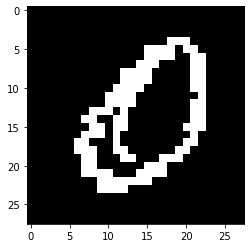

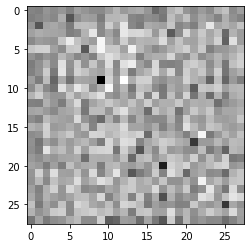

In [29]:
# playground
# Nothing works, although the evaluation is quite good
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x.numpy(), cmap="Greys")
plt.show()
x_ = vae(tf.reshape(x, (1,28,28,1)))
plt.imshow(x_.mean().numpy().reshape(28,28), cmap="Greys")

plt.show()
vae.outputs
